In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [23]:
import pandas as pd

# Try Latin-1 encoding (common for European data)
df = pd.read_csv('../data/raw/OnlineRetail.csv', encoding='ISO-8859-1')

print("="*60)
print("DATASET LOADED SUCCESSFULLY")
print("="*60)
print(f"\nShape: {df.shape}")
print("\nFirst few rows:")
df.head()

DATASET LOADED SUCCESSFULLY

Shape: (541909, 8)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


In [24]:
print("\n" + "="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})

print(missing_df[missing_df['Missing Count'] > 0])

print("\n📊 KEY INSIGHT:")
print(f"   - {missing['CustomerID']:,} rows missing CustomerID ({missing_pct['CustomerID']}%)")
print(f"   - These represent guest checkouts or data quality issues")
print(f"   - We'll remove these since we can't analyze customers without IDs")


MISSING VALUES ANALYSIS
             Missing Count  Percentage
Description           1454        0.27
CustomerID          135080       24.93

📊 KEY INSIGHT:
   - 135,080 rows missing CustomerID (24.93%)
   - These represent guest checkouts or data quality issues
   - We'll remove these since we can't analyze customers without IDs


In [25]:
print("\n" + "="*60)
print("TIME PERIOD ANALYSIS")
print("="*60)

# Convert InvoiceDate to datetime if it's not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Data spans from: {df['InvoiceDate'].min()}")
print(f"             to: {df['InvoiceDate'].max()}")
print(f"Total days: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days}")

print("\n📊 KEY INSIGHT:")
print("   - About 1 year of transaction history")
print("   - This is enough to identify seasonal patterns and customer behavior")


TIME PERIOD ANALYSIS
Data spans from: 2010-12-01 08:26:00
             to: 2011-12-09 12:50:00
Total days: 373

📊 KEY INSIGHT:
   - About 1 year of transaction history
   - This is enough to identify seasonal patterns and customer behavior


In [26]:
print("\n" + "="*60)
print("RETURNS & CANCELLATIONS")
print("="*60)

returns = df[df['Quantity'] < 0]
print(f"Total returns: {len(returns):,} ({len(returns)/len(df)*100:.2f}%)")

cancelled_invoices = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Cancelled invoices: {len(cancelled_invoices):,}")

print("\n📊 KEY INSIGHT:")
print("   - Negative quantities = product returns")
print("   - Invoice numbers starting with 'C' = cancellations")
print("   - We'll handle these when calculating revenue metrics")


RETURNS & CANCELLATIONS
Total returns: 10,624 (1.96%)
Cancelled invoices: 9,288

📊 KEY INSIGHT:
   - Negative quantities = product returns
   - Invoice numbers starting with 'C' = cancellations
   - We'll handle these when calculating revenue metrics


In [27]:
print("\n" + "="*60)
print("CREATING CLEAN DATASET")
print("="*60)

# Remove rows without CustomerID
df_clean = df[df['CustomerID'].notna()].copy()

print(f"Original rows: {len(df):,}")
print(f"After removing null CustomerID: {len(df_clean):,}")
print(f"Rows removed: {len(df) - len(df_clean):,}")

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

print("\n✅ Created 'TotalPrice' column (Quantity × UnitPrice)")
print("\nSample of clean data:")
df_clean[['InvoiceNo', 'Quantity', 'UnitPrice', 'TotalPrice', 'CustomerID']].head(10)


CREATING CLEAN DATASET
Original rows: 541,909
After removing null CustomerID: 406,829
Rows removed: 135,080

✅ Created 'TotalPrice' column (Quantity × UnitPrice)

Sample of clean data:


,InvoiceNo,Quantity,UnitPrice,TotalPrice,CustomerID
0,536365,6,2.55,15.30,17850.00
1,536365,6,3.39,20.34,17850.00
2,536365,8,2.75,22.00,17850.00
3,536365,6,3.39,20.34,17850.00
4,536365,6,3.39,20.34,17850.00
5,536365,2,7.65,15.30,17850.00
6,536365,6,4.25,25.50,17850.00
7,536366,6,1.85,11.10,17850.00
8,536366,6,1.85,11.10,17850.00
9,536367,32,1.69,54.08,13047.00


In [28]:
print("\n" + "="*60)
print("BUSINESS METRICS")
print("="*60)

# Filter out returns for revenue calculation
sales_only = df_clean[df_clean['TotalPrice'] > 0]

total_revenue = sales_only['TotalPrice'].sum()
total_orders = df_clean['InvoiceNo'].nunique()
total_customers = df_clean['CustomerID'].nunique()
total_products = df_clean['StockCode'].nunique()

print(f"💰 Total Revenue: £{total_revenue:,.2f}")
print(f"📦 Total Orders: {total_orders:,}")
print(f"👥 Total Customers: {total_customers:,}")
print(f"📊 Unique Products: {total_products:,}")

avg_order_value = total_revenue / total_orders
avg_customer_value = total_revenue / total_customers

print(f"\n📈 Average Order Value: £{avg_order_value:.2f}")
print(f"📈 Average Customer Lifetime Value: £{avg_customer_value:.2f}")


BUSINESS METRICS
💰 Total Revenue: £8,911,407.90
📦 Total Orders: 22,190
👥 Total Customers: 4,372
📊 Unique Products: 3,684

📈 Average Order Value: £401.60
📈 Average Customer Lifetime Value: £2038.29


In [29]:
print("\n" + "="*60)
print("GEOGRAPHIC DISTRIBUTION")
print("="*60)

country_dist = df_clean['Country'].value_counts().head(10)
print("\nTop 10 Countries by Transaction Count:")
print(country_dist)

print(f"\n📊 KEY INSIGHT:")
print(f"   - {country_dist.iloc[0]:,} transactions from UK ({country_dist.iloc[0]/len(df_clean)*100:.1f}%)")
print(f"   - Primarily UK-focused business with some international sales")


GEOGRAPHIC DISTRIBUTION

Top 10 Countries by Transaction Count:
Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         1877
Portugal            1480
Australia           1259
Name: count, dtype: int64

📊 KEY INSIGHT:
   - 361,878 transactions from UK (89.0%)
   - Primarily UK-focused business with some international sales


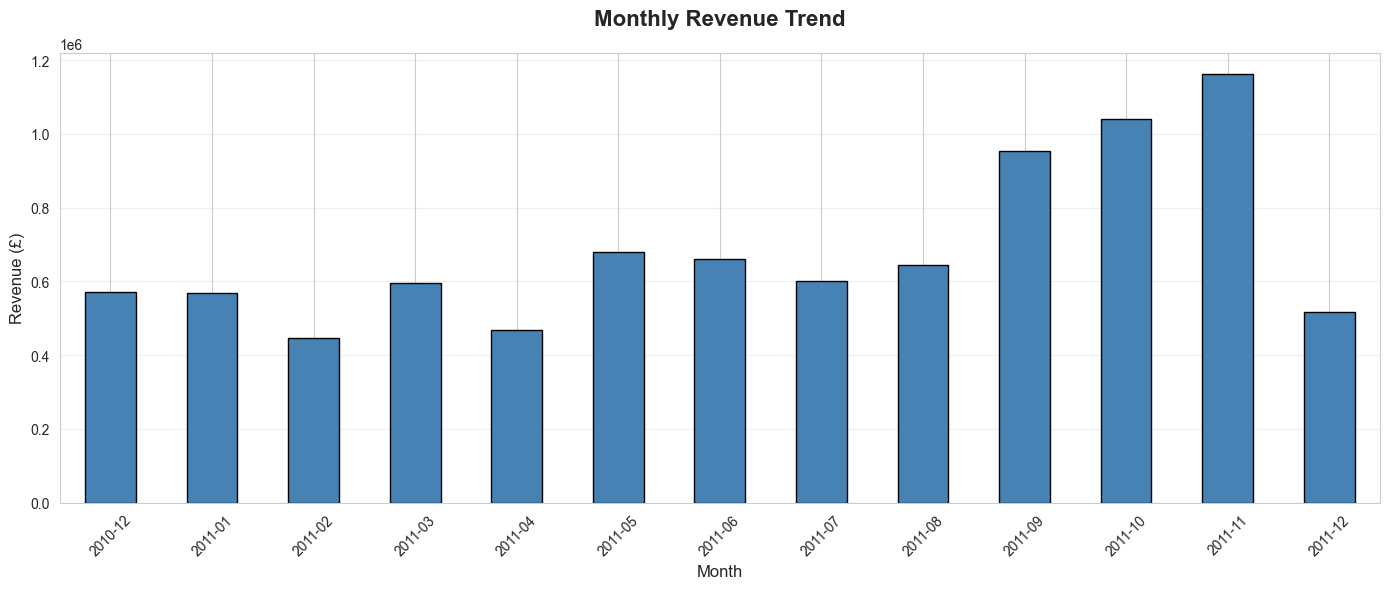


✅ Chart saved to: outputs/figures/monthly_revenue.png


In [31]:
# Create month column on df_clean first
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')

# Now filter for sales only (AFTER creating YearMonth)
sales_only = df_clean[df_clean['TotalPrice'] > 0].copy()

# Calculate monthly revenue
monthly_revenue = sales_only.groupby('YearMonth')['TotalPrice'].sum()

# Plot
plt.figure(figsize=(14, 6))
monthly_revenue.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Monthly Revenue Trend', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('../outputs/figures/monthly_revenue.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved to: outputs/figures/monthly_revenue.png")